# Extracting wake and filtering it out of data

Restarting from the downsampled xrarray, extraction of active (without SWR) and quiet wake (with SWR) periods and removing these periods from the recordings.

## Load EMG and packages

In [1]:
import scipy
from scipy import signal
from scipy import interpolate
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import pandas as pd
import quantities as pq
import neo
from pathlib import Path
import xarray as xr
from IPython.display import display
from ipyfilechooser import FileChooser
import os
from ephyviewer import mkQApp, MainViewer, TraceViewer

%matplotlib widget


In [2]:
dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"
try:
    %store -r dpath
except:
    print("data not in strore")
    dpath ="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"


# Set up Initial Basic Parameters#
minian_path = "."

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>OpenEphys Folder</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recordi…

In [3]:
folder_base = Path(dpath)

filename2 = folder_base / f'RawDataChannelExtractedDS.npy'
All = np.load(filename2, mmap_mode= 'r')

Channels = '//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/LFPChannels_perMice.xlsx' 
allchannels = pd.read_excel(Channels)

mice = os.path.basename(os.path.dirname(os.path.dirname(folder_base)))

EMGch=int(allchannels[mice][3])
EMG  =  All[:, EMGch]


## High pass filter

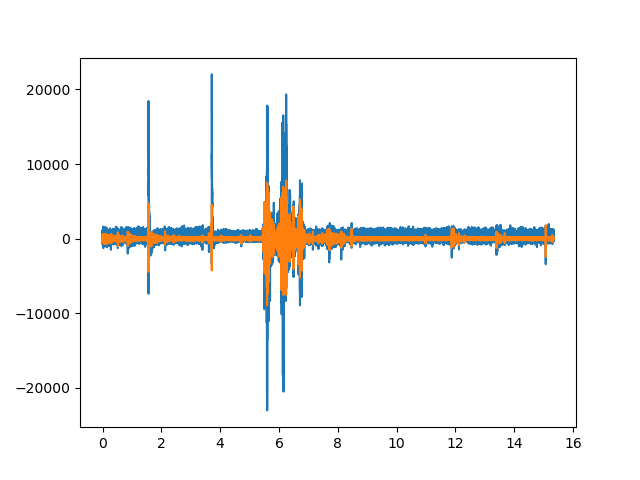

In [6]:
# Filter parameter :
f_lowcut = 200.
f_hicut = 400.
N = 4
fs = 1000
nyq = 0.5 * fs
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction


# Filter creation :
b, a = signal.butter(N, Wn, 'band')
filt_EMG = signal.filtfilt(b, a, EMG)

# Plot
times = np.arange(0, EMG.size/fs, 1./fs)
timesmin = np.arange(0, EMG.size/fs/60, 1./fs/60)

fig, ax = plt.subplots()
ax.plot(timesmin, EMG)
ax.plot(timesmin, filt_EMG)


## Continuous Wavelet Transform and projection calculation

In [22]:
# Parameter and computation of CWT
w = 4.
freq = np.linspace(200, 400, 50)
widths = w*fs / (2*freq*np.pi)
EMGcwt = signal.cwt(EMG, signal.morlet2, widths, w=w)

# Projection calculation
absEMGcwt = np.absolute(EMGcwt)
proj_EMGcwt = np.sum(absEMGcwt, axis = 0)/50
mproj_EMGcwt = np.mean(proj_EMGcwt)
sdproj_EMGcwt = np.std(proj_EMGcwt)
sd3proj_EMGcwt = mproj_EMGcwt + sdproj_EMGcwt*3
sd05proj_EMGcwt = mproj_EMGcwt + sdproj_EMGcwt*0.5
sd1proj_EMGcwt = mproj_EMGcwt + sdproj_EMGcwt

### Display subset 

Not necessary cell to run

In [ ]:
#sd3proj_EMGcwt = mproj_EMGcwt + sdproj_EMGcwt*2
#sd05proj_EMGcwt = mproj_EMGcwt + sdproj_EMGcwt*1.5

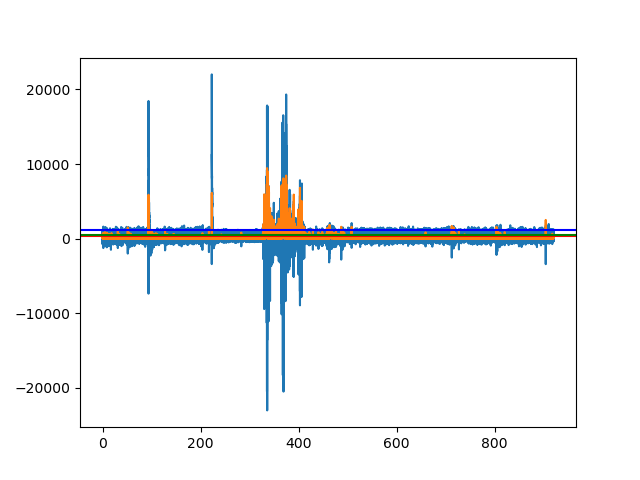

In [23]:
# Defining subset
start = 000000
end =   13000000

tt = times[start:end]
EMGt = EMG[start:end]
EMGcwtt = EMGcwt[:, start:end]
proj_EMGcwtt = proj_EMGcwt[start:end]

plt.close()
plt.plot(tt, EMGt)
plt.plot(tt, proj_EMGcwtt)
plt.axhline(sd05proj_EMGcwt, color='r') # horizontal
plt.axhline(sd1proj_EMGcwt, color='g') # horizontal
plt.axhline(sd3proj_EMGcwt, color='b') # horizontal
plt.show()

## WARNING: Plot only short subsets (~ 10 s), too memory consuming otherwise
#plt.pcolormesh(tt, freq, np.abs(EMGcwt), cmap='viridis', shading='gouraud')
#plt.plot(tt, EMGt)
#plt.show()



## Interpretating signal to extract wake (active and quiet) and sleep

In [31]:
# Assigning values wake (1, 2) and sleep (0)
numpnts = EMG.size
EMGstatusRaw = np.zeros(numpnts)
for ind in range(numpnts):
    if proj_EMGcwt[ind]<sd1proj_EMGcwt:
        EMGstatusRaw[ind] = 0
    elif proj_EMGcwt[ind]>sd3proj_EMGcwt:
        EMGstatusRaw[ind] = 2
    else:
        EMGstatusRaw[ind] = 1

# Expanding borders for wake (1, 2) and sleep (0) to ±1 s around detected muscular activity
EMGstatusRaw2 = np.zeros(numpnts)
for ind in range(numpnts):
    if EMGstatusRaw[ind]>1:
       EMGstatusRaw2[ind-1000:ind+1000] = 2
    elif EMGstatusRaw[ind]==1:
        for ind2 in range(ind-1000, ind+1000):
            if ind2==numpnts:
                break
            elif EMGstatusRaw2[ind2]<2:
                EMGstatusRaw2[ind2] = 1

## To Create boolean masks and to save recordings without movement
#### Creating two masks: one conservative excludes weak muscular activity that can be quiet wake or dozing and one liberal that includes weak muscular activity

In [32]:
EMGStatusBoolLib = (EMGstatusRaw2>1)
EMGStatusBoolCons = (EMGstatusRaw2>0)

#### Removing wake time from the recordings.
Two files created one with 0 instead of signal during wake and one with the wake time removed

In [39]:
LFP = All[:,:]
LFPwake0 = LFP.copy()
LFPwake0[EMGStatusBoolLib] = 0
filename = folder_base/ f'LFPwake0_AB.npy'
np.save(filename, LFPwake0)

LFPwakeremoved = LFP.copy()
LFPwakeremoved = LFPwakeremoved[~EMGStatusBoolLib, :]
filename = folder_base/ f'LFPwakeremoved_AB.npy'
np.save(filename, LFPwakeremoved)
data = {
    'EMGstatus': EMGstatusRaw2,
    'BooleanLiberal' : EMGStatusBoolLib,
    'BooleanConservative' : EMGStatusBoolCons
}
WakeFrame = pd.DataFrame(data, columns=['EMGstatus', 'BooleanLiberal', 'BooleanConservative'])
filename = folder_base/ f'EMGframeBoolean_AB.pkl'

WakeFrame.to_pickle(filename)
# if done and no intention to display for assessment
#%reset
#plt.close('all')

In [47]:
EMGStatusBoolLib

array([False, False, False, ..., False, False, False])

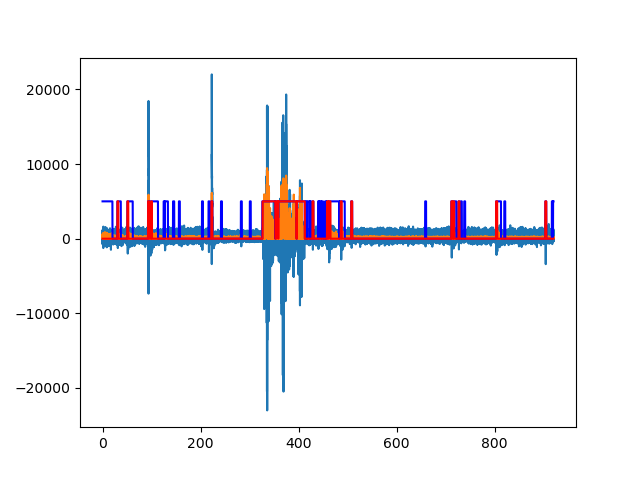

In [53]:
BoolLib = np.zeros(len(EMGt))
BoolLib[EMGStatusBoolLib] = 1
BoolCons = np.zeros(len(EMGt))
BoolCons[EMGStatusBoolCons] = 1
#EMGStatusBoolLib = Bool.BooleanConservative

plt.close()
plt.plot(tt, EMGt)
plt.plot(tt, proj_EMGcwtt)
plt.plot(tt, BoolCons*5000, 'b') # horizontal
plt.plot(tt, BoolLib*5000, 'r') # horizontal
plt.show()

In [15]:
#filename = folder_base/ f'RawDataChannelExtractedDS.npy'
#np.save(filename, all)